
### References :

[1] Baseline method

https://www.kaggle.com/namanj27/new-baseline-pytorch-moa?scriptVersionId=42580548

[2] About RankGauss

https://www.kaggle.com/c/porto-seguro-safe-driver-prediction/discussion/44629

In [1]:
%%HTML
<style type="text/css">
div.h1 {
    background-color:#e17b34; 
    color: white; 
    padding: 8px; 
    padding-right: 300px; 
    font-size: 35px; 
    max-width: 1500px; 
    margin: auto; 
    margin-top: 50px;
}

div.h2 {
    background-color:#83ccd2; 
    color: white; 
    padding: 8px; 
    padding-right: 300px; 
    font-size: 35px; 
    max-width: 1500px; 
    margin: auto; 
    margin-top: 50px;
}
</style>

## If you like, please Upvote😹

# <div class="h1">About this notebook</div>

I use RankGauss to g-* and c-* columns for preprocessing. 

I found score improvement from baseline[1] (CV: 0.014650792660668535, LB:0.01873).

- **CV**: 0.01463430775798657 (check ver1 of this notebook.)

- **LB**: 0.01867


Some kagglers try to use PCA for dimensionality reduction and found good effect.

I won't explain it now, but some people say it is best that the data for PCA has a multivariate normal distribution.

In this notebook, by RankGauss, I processed the data to normal distribute-like data, and see it's effect to scores.

In [2]:
import sys
sys.path.append('../input/iterative-stratification/iterative-stratification-master')
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold

In [3]:
import numpy as np
import random
import pandas as pd
import matplotlib.pyplot as plt
import os
import copy
import seaborn as sns

from sklearn import preprocessing
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import warnings
warnings.filterwarnings('ignore')

In [4]:
from sklearn.preprocessing import QuantileTransformer

In [5]:
os.listdir('../input/lish-moa')

['train_targets_scored.csv',
 'sample_submission.csv',
 'train_drug.csv',
 'train_targets_nonscored.csv',
 'train_features.csv',
 'test_features.csv']

In [6]:
train_features = pd.read_csv('../input/lish-moa/train_features.csv')
train_targets_scored = pd.read_csv('../input/lish-moa/train_targets_scored.csv')
train_targets_nonscored = pd.read_csv('../input/lish-moa/train_targets_nonscored.csv')

test_features = pd.read_csv('../input/lish-moa/test_features.csv')
sample_submission = pd.read_csv('../input/lish-moa/sample_submission.csv')

In [7]:
GENES = [col for col in train_features.columns if col.startswith('g-')]
CELLS = [col for col in train_features.columns if col.startswith('c-')]

I'll check distributions of g-* and c-* of train and test set. They are spiky distribution rather than normal distribution. Regardless of the train and test, they look be in the same shape.



**train set before using RankGauss**

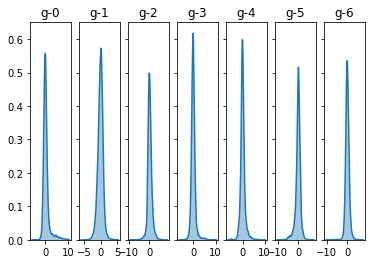

In [8]:
gnum = train_features[GENES].shape[1]
graphs = []

for i in range(0, gnum -1 , 7):
    #for least display.... 
    if i >= 3:
        break
    idxs = list(np.array([0, 1, 2, 3, 4, 5, 6]) + i)
    

    fig, axs = plt.subplots(1, 7, sharey=True)
    for k, item in enumerate(idxs):
        if item >=771:
            break
        graph = sns.distplot(train_features[GENES].values[:,item], ax=axs[k])
        graph.set_title(f"g-{item}")
        graphs.append(graph)

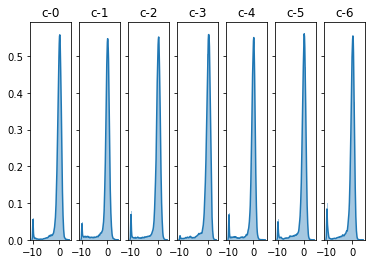

In [9]:
cnum = train_features[CELLS].shape[1]
graphs = []

for i in range(0, cnum -1 , 7):
    #for least display.... 
    if i >= 3:
        break
    idxs = list(np.array([0, 1, 2, 3, 4, 5, 6]) + i)
    

    fig, axs = plt.subplots(1, 7, sharey=True)
    for k, item in enumerate(idxs):
        if item >=100:
            break
        graph = sns.distplot(train_features[CELLS].values[:,item], ax=axs[k])
        graph.set_title(f"c-{item}")
        graphs.append(graph)

**test set before using RankGauss**

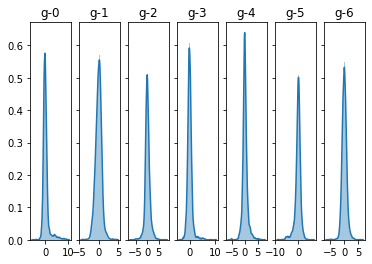

In [10]:
gnum = test_features[GENES].shape[1]
graphs = []

for i in range(0, gnum -1 , 7):
    #for least display.... 
    if i >= 3:
        break
    idxs = list(np.array([0, 1, 2, 3, 4, 5, 6]) + i)
    

    fig, axs = plt.subplots(1, 7, sharey=True)
    for k, item in enumerate(idxs):
        if item >=771:
            break
        graph = sns.distplot(test_features[GENES].values[:,item], ax=axs[k])
        graph.set_title(f"g-{item}")
        graphs.append(graph)

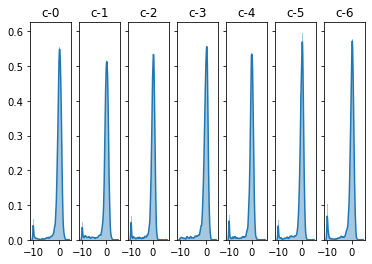

In [11]:
cnum = test_features[CELLS].shape[1]
graphs = []

for i in range(0, cnum -1 , 7):
    #for least display.... 
    if i >= 3:
        break
    idxs = list(np.array([0, 1, 2, 3, 4, 5, 6]) + i)
    

    fig, axs = plt.subplots(1, 7, sharey=True)
    for k, item in enumerate(idxs):
        if item >=100:
            break
        graph = sns.distplot(test_features[CELLS].values[:,item], ax=axs[k])
        graph.set_title(f"c-{item}")
        graphs.append(graph)

It may be a too simple idea, it appears that the gene expression data and cell viability data can be controlled by the experimenter, so it is safe to assume that these data are independent of each other.

Also, since the shape of the distribution is close to normal distribution to begin with, I don't think there is much of a problem if it is forced to be transformed into a Gaussian distribution.

### In this kernel I add RankGauss here. ↓↓↓

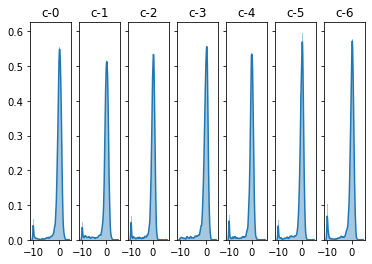

In [12]:
cnum = test_features[CELLS].shape[1]
graphs = []

for i in range(0, cnum -1 , 7):
    #for least display.... 
    if i >= 3:
        break
    idxs = list(np.array([0, 1, 2, 3, 4, 5, 6]) + i)
    

    fig, axs = plt.subplots(1, 7, sharey=True)
    for k, item in enumerate(idxs):
        if item >=100:
            break
        graph = sns.distplot(test_features[CELLS].values[:,item], ax=axs[k])
        graph.set_title(f"c-{item}")
        graphs.append(graph)

It appears that we were able to transform the distribution of each data to resemble a normal distribution, as intended.

So, let's enter the data into the benchmarking method to see the improvement.

In [13]:
train_features_ids = train_features.loc[:,'sig_id':'cp_dose']
train_features_only = train_features.iloc[:,4:]

train_features_only_columns = train_features_only.columns
train_features_only_values = train_features_only.values

train_features_only_values_arcsinh = np.arcsinh(train_features_only_values)
train_features_only_arcsinh = pd.DataFrame(train_features_only_values_arcsinh, columns=train_features_only_columns)

train_features = pd.concat([train_features_ids, train_features_only_arcsinh], axis=1)


test_features_ids = test_features.loc[:,'sig_id':'cp_dose']
test_features_only = test_features.iloc[:,4:]

test_features_only_columns = test_features_only.columns
test_features_only_values = test_features_only.values

test_features_only_values_arcsinh = np.arcsinh(test_features_only_values)
test_features_only_arcsinh = pd.DataFrame(test_features_only_values_arcsinh, columns=test_features_only_columns)

test_features = pd.concat([test_features_ids, test_features_only_arcsinh], axis=1)

# <div class="h2">Evaluation of preprocessed data</div>



I use the great notebook(refer [1]https://www.kaggle.com/namanj27/new-baseline-pytorch-moa?scriptVersionId=42580548) for benchmark.

In [14]:
def seed_everything(seed=42):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True
    
seed_everything(seed=42)

In [15]:
train_targets_scored.sum()[1:].sort_values()

atp-sensitive_potassium_channel_antagonist      1
erbb2_inhibitor                                 1
diuretic                                        6
autotaxin_inhibitor                             6
protein_phosphatase_inhibitor                   6
                                             ... 
serotonin_receptor_antagonist                 404
dopamine_receptor_antagonist                  424
cyclooxygenase_inhibitor                      435
proteasome_inhibitor                          726
nfkb_inhibitor                                832
Length: 206, dtype: object

In [16]:
train_features['cp_type'].unique()

array(['trt_cp', 'ctl_vehicle'], dtype=object)

# PCA features + Existing features

In [17]:
# GENES
n_comp = 50

data = pd.concat([pd.DataFrame(train_features[GENES]), pd.DataFrame(test_features[GENES])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[GENES]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_G-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_G-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(GENES))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

In [18]:
#CELLS
n_comp = 15

data = pd.concat([pd.DataFrame(train_features[CELLS]), pd.DataFrame(test_features[CELLS])])
data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
train2 = data2[:train_features.shape[0]]; test2 = data2[-test_features.shape[0]:]

train2 = pd.DataFrame(train2, columns=[f'pca_C-{i}' for i in range(n_comp)])
test2 = pd.DataFrame(test2, columns=[f'pca_C-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
train_features = pd.concat((train_features, train2), axis=1)
test_features = pd.concat((test_features, test2), axis=1)

# feature Selection using Variance Encoding

In [19]:
from sklearn.feature_selection import VarianceThreshold


var_thresh = VarianceThreshold(threshold=0.5)
data = train_features.append(test_features)
data_transformed = var_thresh.fit_transform(data.iloc[:, 4:])

train_features_transformed = data_transformed[ : train_features.shape[0]]
test_features_transformed = data_transformed[-test_features.shape[0] : ]


train_features = pd.DataFrame(train_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                              columns=['sig_id','cp_type','cp_time','cp_dose'])

train_features = pd.concat([train_features, pd.DataFrame(train_features_transformed)], axis=1)


test_features = pd.DataFrame(test_features[['sig_id','cp_type','cp_time','cp_dose']].values.reshape(-1, 4),\
                             columns=['sig_id','cp_type','cp_time','cp_dose'])

test_features = pd.concat([test_features, pd.DataFrame(test_features_transformed)], axis=1)

train_features


,sig_id,cp_type,cp_time,cp_dose,0,1,2,3,4,5,...,751,752,753,754,755,756,757,758,759,760
0,id_000644bb2,trt_cp,24,D1,0.924542,-0.245429,-0.193196,-0.889833,-0.032594,0.529682,...,0.275946,0.522876,0.954310,0.070877,-4.182301,1.139656,-0.358076,-0.591338,-1.267944,-0.371954
1,id_000779bfc,trt_cp,72,D1,0.074232,0.294811,0.894745,0.499649,0.331116,-0.394396,...,-0.249593,0.349974,-1.042268,0.569399,-4.460643,-0.384438,-0.100620,0.128232,-0.134756,-0.037167
2,id_000a6266a,trt_cp,48,D1,0.592686,1.224349,-0.032294,1.040703,0.213866,0.006500,...,0.470974,-1.339443,0.420461,3.035231,0.255816,0.340416,0.292057,-0.164038,0.178581,0.259406
3,id_0015fd391,trt_cp,48,D1,-0.493521,-0.262572,2.109641,-0.740069,0.178255,-0.131719,...,1.173178,1.108097,-0.628514,0.482831,10.608481,3.053666,0.577641,2.137766,-1.776745,-0.005608
4,id_001626bd3,trt_cp,72,D2,-0.319915,0.860000,1.148400,-0.751608,-0.149245,-0.793101,...,-0.039363,-0.686900,-0.554094,-0.286692,-3.356714,0.571803,0.182429,-0.384970,0.220216,0.274467
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,trt_cp,24,D2,0.138952,-0.110972,-0.455396,0.669055,0.300937,-0.456571,...,-0.378988,-0.381249,0.699683,0.030168,-3.378359,0.038481,-0.184636,0.930089,0.582960,-0.089196
23810,id_fffb70c0c,trt_cp,24,D2,-1.094205,-0.366069,-0.667188,0.621341,-0.531168,0.491207,...,-1.969647,-0.714714,-1.004308,0.565701,-1.285082,0.344391,-0.979339,-1.237879,0.986789,0.882858
23811,id_fffc1c3f4,ctl_vehicle,48,D2,0.384645,0.306098,0.525919,-0.015899,0.173626,-0.033993,...,0.918032,1.122845,0.531715,1.019707,-5.229789,0.648579,-0.424371,0.170522,-0.286685,-0.433326
23812,id_fffcb9e7c,trt_cp,24,D1,0.624590,0.426181,0.773598,-0.034293,0.046283,0.417652,...,-0.464639,-0.233224,-1.173490,0.582881,-4.636425,0.998320,-0.408157,-0.356822,0.784898,-0.916316


In [20]:
train = train_features.merge(train_targets_scored, on='sig_id')
train = train[train['cp_type']!='ctl_vehicle'].reset_index(drop=True)
test = test_features[test_features['cp_type']!='ctl_vehicle'].reset_index(drop=True)

target = train[train_targets_scored.columns]

In [21]:
train = train.drop('cp_type', axis=1)
test = test.drop('cp_type', axis=1)

In [22]:
train

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,24,D1,0.924542,-0.245429,-0.193196,-0.889833,-0.032594,0.529682,-0.091970,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,72,D1,0.074232,0.294811,0.894745,0.499649,0.331116,-0.394396,0.771771,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,48,D1,0.592686,1.224349,-0.032294,1.040703,0.213866,0.006500,1.035038,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,48,D1,-0.493521,-0.262572,2.109641,-0.740069,0.178255,-0.131719,-0.923170,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,72,D2,-0.319915,0.860000,1.148400,-0.751608,-0.149245,-0.793101,0.781111,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,id_fff8c2444,72,D1,0.160115,0.252411,-0.240767,0.413698,-0.176778,-0.691546,0.136377,...,0,0,0,0,0,0,0,0,0,0
21944,id_fffb1ceed,24,D2,0.138952,-0.110972,-0.455396,0.669055,0.300937,-0.456571,0.126562,...,0,0,0,0,0,0,0,0,0,0
21945,id_fffb70c0c,24,D2,-1.094205,-0.366069,-0.667188,0.621341,-0.531168,0.491207,0.630158,...,0,0,0,0,0,0,0,0,0,0
21946,id_fffcb9e7c,24,D1,0.624590,0.426181,0.773598,-0.034293,0.046283,0.417652,-0.731497,...,0,0,0,0,0,0,0,0,0,0


# Binning

In [23]:
# for col in GENES:
#     train.loc[:, f'{col}_bin'] = pd.cut(train[col], bins=3, labels=False)
#     test.loc[:, f'{col}_bin'] = pd.cut(test[col], bins=3, labels=False)


# Distribution plots

In [24]:
# plt.figure(figsize=(16,16))
# sns.set_style("whitegrid")

# gene_choice = np.random.choice(len(GENES), 16)
# for i, col in enumerate(gene_choice):
#     plt.subplot(4, 4, i+1)
#     plt.hist(train_features.loc[:, GENES[col]],bins=100, color='orange')
#     plt.title(GENES[col])

# [Naive] Outlier Removal

In [25]:

# train_ = train.copy() [Didn't wanted to actually normalize, so created a copy and normalized that for further calculation]
# for col in GENES:
    
# #     train_[col] = (train[col]-np.mean(train[col])) / (np.std(train[col]))
    
#     mean = train_[col].mean()
#     std = train_[col].std()

#     std_r = mean + 4*std
#     std_l = mean - 4*std

#     drop = train_[col][(train_[col]>std_r) | (train_[col]<std_l)].index.values

# train = train.drop(drop).reset_index(drop=True)
# # folds = folds.drop(drop).reset_index(drop=True)
# target = target.drop(drop).reset_index(drop=True)


# PCA

In [26]:
# n_comp = 50

# data = pd.concat([pd.DataFrame(train[CELLS]), pd.DataFrame(test[CELLS])])
# data2 = (PCA(n_components=n_comp, random_state=42).fit_transform(data[CELLS]))
# train2 = data2[:train.shape[0]]; test2 = data2[train.shape[0]:]

# train2 = pd.DataFrame(train2, columns=[f'c-{i}' for i in range(n_comp)])
# test2 = pd.DataFrame(test2, columns=[f'c-{i}' for i in range(n_comp)])

# drop_cols = [f'c-{i}' for i in range(n_comp,len(CELLS))]
# train = train.drop(columns=drop_cols)
# test = test.drop(columns=drop_cols)

In [27]:
target_cols = target.drop('sig_id', axis=1).columns.values.tolist()

# CV folds

In [28]:
folds = train.copy()

mskf = MultilabelStratifiedKFold(n_splits=5)

for f, (t_idx, v_idx) in enumerate(mskf.split(X=train, y=target)):
    folds.loc[v_idx, 'kfold'] = int(f)

folds['kfold'] = folds['kfold'].astype(int)
folds

,sig_id,cp_time,cp_dose,0,1,2,3,4,5,6,...,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor,kfold
0,id_000644bb2,24,D1,0.924542,-0.245429,-0.193196,-0.889833,-0.032594,0.529682,-0.091970,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,72,D1,0.074232,0.294811,0.894745,0.499649,0.331116,-0.394396,0.771771,...,0,0,0,0,0,0,0,0,0,2
2,id_000a6266a,48,D1,0.592686,1.224349,-0.032294,1.040703,0.213866,0.006500,1.035038,...,0,0,0,0,0,0,0,0,0,1
3,id_0015fd391,48,D1,-0.493521,-0.262572,2.109641,-0.740069,0.178255,-0.131719,-0.923170,...,0,0,0,0,0,0,0,0,0,2
4,id_001626bd3,72,D2,-0.319915,0.860000,1.148400,-0.751608,-0.149245,-0.793101,0.781111,...,0,0,0,0,0,0,0,0,0,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
21943,id_fff8c2444,72,D1,0.160115,0.252411,-0.240767,0.413698,-0.176778,-0.691546,0.136377,...,0,0,0,0,0,0,0,0,0,0
21944,id_fffb1ceed,24,D2,0.138952,-0.110972,-0.455396,0.669055,0.300937,-0.456571,0.126562,...,0,0,0,0,0,0,0,0,0,4
21945,id_fffb70c0c,24,D2,-1.094205,-0.366069,-0.667188,0.621341,-0.531168,0.491207,0.630158,...,0,0,0,0,0,0,0,0,0,0
21946,id_fffcb9e7c,24,D1,0.624590,0.426181,0.773598,-0.034293,0.046283,0.417652,-0.731497,...,0,0,0,0,0,0,0,0,0,1


In [29]:
print(train.shape)
print(folds.shape)
print(test.shape)
print(target.shape)
print(sample_submission.shape)

(21948, 970)
(21948, 971)
(3624, 764)
(21948, 207)
(3982, 207)


# Dataset Classes

In [30]:
class MoADataset:
    def __init__(self, features, targets):
        self.features = features
        self.targets = targets
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float),
            'y' : torch.tensor(self.targets[idx, :], dtype=torch.float)            
        }
        return dct
    
class TestDataset:
    def __init__(self, features):
        self.features = features
        
    def __len__(self):
        return (self.features.shape[0])
    
    def __getitem__(self, idx):
        dct = {
            'x' : torch.tensor(self.features[idx, :], dtype=torch.float)
        }
        return dct
    

In [31]:
def train_fn(model, optimizer, scheduler, loss_fn, dataloader, device):
    model.train()
    final_loss = 0
    
    for data in dataloader:
        optimizer.zero_grad()
        inputs, targets = data['x'].to(device), data['y'].to(device)
#         print(inputs.shape)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        loss.backward()
        optimizer.step()
        scheduler.step()
        
        final_loss += loss.item()
        
    final_loss /= len(dataloader)
    
    return final_loss


def valid_fn(model, loss_fn, dataloader, device):
    model.eval()
    final_loss = 0
    valid_preds = []
    
    for data in dataloader:
        inputs, targets = data['x'].to(device), data['y'].to(device)
        outputs = model(inputs)
        loss = loss_fn(outputs, targets)
        
        final_loss += loss.item()
        valid_preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    final_loss /= len(dataloader)
    valid_preds = np.concatenate(valid_preds)
    
    return final_loss, valid_preds

def inference_fn(model, dataloader, device):
    model.eval()
    preds = []
    
    for data in dataloader:
        inputs = data['x'].to(device)

        with torch.no_grad():
            outputs = model(inputs)
        
        preds.append(outputs.sigmoid().detach().cpu().numpy())
        
    preds = np.concatenate(preds)
    
    return preds
   
    

# Model

In [32]:
class Model(nn.Module):
    def __init__(self, num_features, num_targets, hidden_size):
        super(Model, self).__init__()
        self.batch_norm1 = nn.BatchNorm1d(num_features)
        self.dropout1 = nn.Dropout(0.2)
        self.dense1 = nn.utils.weight_norm(nn.Linear(num_features, hidden_size))
        
        self.batch_norm2 = nn.BatchNorm1d(hidden_size)
        self.dropout2 = nn.Dropout(0.5)
        self.dense2 = nn.utils.weight_norm(nn.Linear(hidden_size, hidden_size))
        
        self.batch_norm3 = nn.BatchNorm1d(hidden_size)
        self.dropout3 = nn.Dropout(0.5)
        self.dense3 = nn.utils.weight_norm(nn.Linear(hidden_size, num_targets))
    
    def forward(self, x):
        x = self.batch_norm1(x)
        x = self.dropout1(x)
        x = F.relu(self.dense1(x))
        
        x = self.batch_norm2(x)
        x = self.dropout2(x)
        x = F.relu(self.dense2(x))
        
        x = self.batch_norm3(x)
        x = self.dropout3(x)
        x = self.dense3(x)
        
        return x

# Preprocessing steps

In [33]:
def process_data(data):
    
    data = pd.get_dummies(data, columns=['cp_time','cp_dose'])
#     data.loc[:, 'cp_time'] = data.loc[:, 'cp_time'].map({24: 0, 48: 1, 72: 2})
#     data.loc[:, 'cp_dose'] = data.loc[:, 'cp_dose'].map({'D1': 0, 'D2': 1})

# --------------------- Normalize ---------------------
#     for col in GENES:
#         data[col] = (data[col]-np.mean(data[col])) / (np.std(data[col]))
    
#     for col in CELLS:
#         data[col] = (data[col]-np.mean(data[col])) / (np.std(data[col]))
    
#--------------------- Removing Skewness ---------------------
#     for col in GENES + CELLS:
#         if(abs(data[col].skew()) > 0.75):
            
#             if(data[col].skew() < 0): # neg-skewness
#                 data[col] = data[col].max() - data[col] + 1
#                 data[col] = np.sqrt(data[col])
            
#             else:
#                 data[col] = np.sqrt(data[col])
    
    return data

In [34]:
feature_cols = [c for c in process_data(folds).columns if c not in target_cols]
feature_cols = [c for c in feature_cols if c not in ['kfold','sig_id']]
len(feature_cols)

766

In [35]:
# HyperParameters

DEVICE = ('cuda' if torch.cuda.is_available() else 'cpu')
EPOCHS = 25
BATCH_SIZE = 128
LEARNING_RATE = 1e-3
WEIGHT_DECAY = 1e-5
NFOLDS = 5
EARLY_STOPPING_STEPS = 10
EARLY_STOP = False

num_features=len(feature_cols)
num_targets=len(target_cols)
hidden_size=1024


# Single fold training

In [36]:
def run_training(fold, seed):
    
    seed_everything(seed)
    
    train = process_data(folds)
    test_ = process_data(test)
    
    trn_idx = train[train['kfold'] != fold].index
    val_idx = train[train['kfold'] == fold].index
    
    train_df = train[train['kfold'] != fold].reset_index(drop=True)
    valid_df = train[train['kfold'] == fold].reset_index(drop=True)
    
    x_train, y_train  = train_df[feature_cols].values, train_df[target_cols].values
    x_valid, y_valid =  valid_df[feature_cols].values, valid_df[target_cols].values
    
    train_dataset = MoADataset(x_train, y_train)
    valid_dataset = MoADataset(x_valid, y_valid)
    trainloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
    validloader = torch.utils.data.DataLoader(valid_dataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.to(DEVICE)
    
    optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE, weight_decay=WEIGHT_DECAY)
    scheduler = optim.lr_scheduler.OneCycleLR(optimizer=optimizer, pct_start=0.1, div_factor=1e3, 
                                              max_lr=1e-2, epochs=EPOCHS, steps_per_epoch=len(trainloader))
    
    loss_fn = nn.BCEWithLogitsLoss()
    
    early_stopping_steps = EARLY_STOPPING_STEPS
    early_step = 0
    
    oof = np.zeros((len(train), target.iloc[:, 1:].shape[1]))
    best_loss = np.inf
    
    for epoch in range(EPOCHS):
        
        train_loss = train_fn(model, optimizer,scheduler, loss_fn, trainloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, train_loss: {train_loss}")
        valid_loss, valid_preds = valid_fn(model, loss_fn, validloader, DEVICE)
        print(f"FOLD: {fold}, EPOCH: {epoch}, valid_loss: {valid_loss}")
        
        if valid_loss < best_loss:
            
            best_loss = valid_loss
            oof[val_idx] = valid_preds
            torch.save(model.state_dict(), f"FOLD{fold}_.pth")
        
        elif(EARLY_STOP == True):
            
            early_step += 1
            if (early_step >= early_stopping_steps):
                break
            
    
    #--------------------- PREDICTION---------------------
    x_test = test_[feature_cols].values
    testdataset = TestDataset(x_test)
    testloader = torch.utils.data.DataLoader(testdataset, batch_size=BATCH_SIZE, shuffle=False)
    
    model = Model(
        num_features=num_features,
        num_targets=num_targets,
        hidden_size=hidden_size,
    )
    
    model.load_state_dict(torch.load(f"FOLD{fold}_.pth"))
    model.to(DEVICE)
    
    predictions = np.zeros((len(test_), target.iloc[:, 1:].shape[1]))
    predictions = inference_fn(model, testloader, DEVICE)
    
    return oof, predictions


In [37]:
def run_k_fold(NFOLDS, seed):
    oof = np.zeros((len(train), len(target_cols)))
    predictions = np.zeros((len(test), len(target_cols)))
    
    for fold in range(NFOLDS):
        oof_, pred_ = run_training(fold, seed)
        
        predictions += pred_ / NFOLDS
        oof += oof_
        
    return oof, predictions

In [38]:
# Averaging on multiple SEEDS

SEED = [0, 1, 2, 3 ,4, 5]
oof = np.zeros((len(train), len(target_cols)))
predictions = np.zeros((len(test), len(target_cols)))

for seed in SEED:
    
    oof_, predictions_ = run_k_fold(NFOLDS, seed)
    oof += oof_ / len(SEED)
    predictions += predictions_ / len(SEED)

train[target_cols] = oof
test[target_cols] = predictions


FOLD: 0, EPOCH: 0, train_loss: 0.5459679536035528
FOLD: 0, EPOCH: 0, valid_loss: 0.03210952367101397
FOLD: 0, EPOCH: 1, train_loss: 0.023531662583675072
FOLD: 0, EPOCH: 1, valid_loss: 0.020366150247199195
FOLD: 0, EPOCH: 2, train_loss: 0.020037127483258213
FOLD: 0, EPOCH: 2, valid_loss: 0.018575820113931385
FOLD: 0, EPOCH: 3, train_loss: 0.018723021031937737
FOLD: 0, EPOCH: 3, valid_loss: 0.017716971305864197
FOLD: 0, EPOCH: 4, train_loss: 0.01804086408726331
FOLD: 0, EPOCH: 4, valid_loss: 0.017554892732628755
FOLD: 0, EPOCH: 5, train_loss: 0.01768336590865384
FOLD: 0, EPOCH: 5, valid_loss: 0.017055968727384296
FOLD: 0, EPOCH: 6, train_loss: 0.01745004001060042
FOLD: 0, EPOCH: 6, valid_loss: 0.017001593325819287
FOLD: 0, EPOCH: 7, train_loss: 0.0173449345688889
FOLD: 0, EPOCH: 7, valid_loss: 0.01691909927342619
FOLD: 0, EPOCH: 8, train_loss: 0.01734482054936065
FOLD: 0, EPOCH: 8, valid_loss: 0.017017053174121038
FOLD: 0, EPOCH: 9, train_loss: 0.017346654438238213
FOLD: 0, EPOCH: 9, val

In [39]:
# test['atp-sensitive_potassium_channel_antagonist'] = 0.0
# test['erbb2_inhibitor'] = 0.0

# train['atp-sensitive_potassium_channel_antagonist'] = 0.0
# train['erbb2_inhibitor'] = 0.0

In [40]:
train_targets_scored

,sig_id,5-alpha_reductase_inhibitor,11-beta-hsd1_inhibitor,acat_inhibitor,acetylcholine_receptor_agonist,acetylcholine_receptor_antagonist,acetylcholinesterase_inhibitor,adenosine_receptor_agonist,adenosine_receptor_antagonist,adenylyl_cyclase_activator,...,tropomyosin_receptor_kinase_inhibitor,trpv_agonist,trpv_antagonist,tubulin_inhibitor,tyrosine_kinase_inhibitor,ubiquitin_specific_protease_inhibitor,vegfr_inhibitor,vitamin_b,vitamin_d_receptor_agonist,wnt_inhibitor
0,id_000644bb2,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,id_000779bfc,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,id_000a6266a,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,id_0015fd391,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,id_001626bd3,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
23809,id_fffb1ceed,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23810,id_fffb70c0c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23811,id_fffc1c3f4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
23812,id_fffcb9e7c,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [41]:
len(target_cols)


206

In [42]:
valid_results = train_targets_scored.drop(columns=target_cols).merge(train[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)


y_true = train_targets_scored[target_cols].values
y_pred = valid_results[target_cols].values

score = 0
for i in range(len(target_cols)):
    score_ = log_loss(y_true[:, i], y_pred[:, i])
    score += score_ / target.shape[1]
    
print("CV log_loss: ", score)
    

CV log_loss:  0.01463012375785274


In [43]:
sub = sample_submission.drop(columns=target_cols).merge(test[['sig_id']+target_cols], on='sig_id', how='left').fillna(0)
sub.to_csv('submission.csv', index=False)

In [44]:
sub.shape

(3982, 207)